# Deep-MINE Framework

## 1. Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import random
import requests
from tqdm import tqdm
tqdm.pandas()

## 2. Loading data

### 2.1 Reviews

In [2]:
# load json
reviews = []
with open('/content/drive/MyDrive/Mestrado/Prime_Pantry.json') as f:
    for line in f:
        reviews.append(json.loads(line))

# create dataframe
df_reviews = pd.DataFrame(reviews)
print(df_reviews.shape)
df_reviews.head()

(471614, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5.0,True,"12 14, 2014",A1NKJW0TNRVS7O,B0000DIWNZ,Tamara M.,Good clinging,Clings well,1418515200,NaN,NaN,NaN
1,4.0,True,"11 20, 2014",A2L6X37E8TFTCC,B0000DIWNZ,Amazon Customer,Fantastic buy and a good plastic wrap. Even t...,Saran could use more Plus to Cling better.,1416441600,NaN,NaN,NaN
2,4.0,True,"10 11, 2014",A2WPR4W6V48121,B0000DIWNZ,noname,ok,Four Stars,1412985600,NaN,NaN,NaN
3,3.0,False,"09 1, 2014",A27EE7X7L29UMU,B0000DIWNZ,ZapNZs,Saran Cling Plus is kind of like most of the C...,"The wrap is fantastic, but the dispensing, cut...",1409529600,4,NaN,NaN
4,4.0,True,"08 10, 2014",A1OWT4YZGB5GV9,B0000DIWNZ,Amy Rogers,This is my go to plastic wrap so there isn't m...,has been doing it's job for years,1407628800,NaN,NaN,NaN


In [3]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471614 entries, 0 to 471613
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         471614 non-null  float64
 1   verified        471614 non-null  bool   
 2   reviewTime      471614 non-null  object 
 3   reviewerID      471614 non-null  object 
 4   asin            471614 non-null  object 
 5   reviewerName    471578 non-null  object 
 6   reviewText      471233 non-null  object 
 7   summary         471473 non-null  object 
 8   unixReviewTime  471614 non-null  int64  
 9   vote            41716 non-null   object 
 10  image           3568 non-null    object 
 11  style           6933 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 40.0+ MB


In [4]:
# data cleaning
df_reviews = df_reviews.dropna(subset=['reviewerID', 'asin', 'reviewText'])
df_reviews = df_reviews[['reviewerID', 'asin', 'reviewText']]
print(df_reviews.shape)
df_reviews.head()

(471233, 3)


,reviewerID,asin,reviewText
0,A1NKJW0TNRVS7O,B0000DIWNZ,Good clinging
1,A2L6X37E8TFTCC,B0000DIWNZ,Fantastic buy and a good plastic wrap. Even t...
2,A2WPR4W6V48121,B0000DIWNZ,ok
3,A27EE7X7L29UMU,B0000DIWNZ,Saran Cling Plus is kind of like most of the C...
4,A1OWT4YZGB5GV9,B0000DIWNZ,This is my go to plastic wrap so there isn't m...


In [5]:
print(f'Number of unique reviewers:', df_reviews['reviewerID'].nunique())

Number of unique reviewers: 247504


In [6]:
print('Total number of unique products that has a review:', df_reviews['asin'].nunique())

Total number of unique products that has a review: 10814


In [7]:
print('Total number of reviews:', df_reviews.shape[0])

Total number of reviews: 471233


In [8]:
# check for any null value
df_reviews.isnull().sum()

,0
reviewerID,0
asin,0
reviewText,0


### 2.2 Products

In [9]:
# load json
products = []
with open('/content/drive/MyDrive/Mestrado/meta_Prime_Pantry.json') as f:
    for line in f:
        products.append(json.loads(line))

# create dataframe
df_products = pd.DataFrame(products)
print(df_products.shape)
df_products.head(2)

(10813, 19)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [10]:
# replace empty lists with null values
df_products = df_products.map(lambda x: np.nan if len(x) == 0 else x)
df_products.head(2)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,NaN,NaN,[Sink your sweet tooth into MILK DUDS Candya d...,NaN,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",NaN,Milk Duds,NaN,NaN,NaN,"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",NaN,NaN,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,NaN,NaN,[Sink your sweet tooth into MILK DUDS Candya d...,NaN,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",NaN,Milk Duds,NaN,NaN,NaN,"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",NaN,NaN,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [11]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10813 entries, 0 to 10812
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         0 non-null      float64
 1   tech1            0 non-null      float64
 2   description      10715 non-null  object 
 3   fit              0 non-null      float64
 4   title            10813 non-null  object 
 5   also_buy         4059 non-null   object 
 6   tech2            0 non-null      float64
 7   brand            10810 non-null  object 
 8   feature          1036 non-null   object 
 9   rank             4876 non-null   object 
 10  also_view        5978 non-null   object 
 11  details          10789 non-null  object 
 12  main_cat         10813 non-null  object 
 13  similar_item     0 non-null      float64
 14  date             0 non-null      float64
 15  price            6750 non-null   object 
 16  asin             10813 non-null  object 
 17  imageURL    

In [12]:
all_products = df_products['asin'].unique()
print('Total number of registred products:', df_products['asin'].shape[0])
print('Total number of unique products:', all_products.shape[0])

Total number of registred products: 10813
Total number of unique products: 10812


In [13]:
# data cleaning
df_products_cleaned = df_products.dropna(subset=['description', 'asin', 'imageURL', 'imageURLHighRes'])
df_products_cleaned = df_products_cleaned[['description', 'asin', 'imageURL', 'imageURLHighRes']]
print(df_products_cleaned.shape)
df_products_cleaned.head(2)

(8942, 4)


,description,asin,imageURL,imageURLHighRes
0,[Sink your sweet tooth into MILK DUDS Candya d...,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[Sink your sweet tooth into MILK DUDS Candya d...,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [14]:
# check for any null value
df_products_cleaned.isnull().sum()

,0
description,0
asin,0
imageURL,0
imageURLHighRes,0


In [15]:
print('Total number of registred products after cleaning:', df_products_cleaned['asin'].shape[0])
print('Total number of unique products after cleaning:', df_products_cleaned['asin'].unique().shape[0])

Total number of registred products after cleaning: 8942
Total number of unique products after cleaning: 8941


In [16]:
# remove the duplicate one
df_products_cleaned = df_products_cleaned.drop_duplicates(subset=['asin'])
df_products_cleaned.shape

(8941, 4)

In [17]:
# choose one image randomly
df_products_cleaned['imageURL'] = df_products_cleaned['imageURL'].apply(lambda x: random.choice(x))

<ipython-input-17-e530d7225ab0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products_cleaned['imageURL'] = df_products_cleaned['imageURL'].apply(lambda x: random.choice(x))


In [18]:
# avoid urls in descriptions
df_products_cleaned['description'] = df_products_cleaned['description'].apply(lambda x: [text for text in x if 'http' not in text]).apply(lambda x: ' '.join(x))

<ipython-input-18-3209fa3dc9a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products_cleaned['description'] = df_products_cleaned['description'].apply(lambda x: [text for text in x if 'http' not in text]).apply(lambda x: ' '.join(x))


In [19]:
df_prime_pantry = df_reviews.merge(df_products_cleaned, on='asin', how='right')  # use `right` to keep products without feedback
print(df_prime_pantry.shape)
df_prime_pantry.head()

(448467, 6)


,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,A2HZ0F1Q8CVX1,B00005BPJO,The outside of them is wet and sticky.. like t...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
1,A3C4FVGQ0FSORL,B00005BPJO,They came white,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
2,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
3,A1CSVASI7B3RTX,B00005BPJO,Very good,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
4,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...


In [20]:
df_reviews.shape[0] - df_prime_pantry.shape[0]

22766

#### Check inconsistencies

In [21]:
# get products that were removed after the cleaning
removed_products = list(set(all_products) - set(df_products_cleaned['asin']))
len(removed_products)

1871

In [22]:
# count how many reviews has that removed products
df_reviews['asin'].isin(removed_products).sum()

np.int64(22706)

Still missing 60 reviews

In [23]:
# does reviews have products that the table of products do not have?
more_products = df_reviews[~df_reviews['asin'].isin(df_products['asin'])]['asin']
more_products.nunique()

2

In [24]:
more_products.unique()

array(['B0014CX19A', 'B0014CXT2O'], dtype=object)

In [25]:
more_products.shape[0]

60

### 2.3 Cleaning final dataset

In [26]:
print(df_prime_pantry.shape)
df_prime_pantry.head()

(448467, 6)


,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,A2HZ0F1Q8CVX1,B00005BPJO,The outside of them is wet and sticky.. like t...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
1,A3C4FVGQ0FSORL,B00005BPJO,They came white,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
2,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
3,A1CSVASI7B3RTX,B00005BPJO,Very good,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
4,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...


In [27]:
print(f'Number of users:', df_prime_pantry['reviewerID'].nunique())

Number of users: 236741


In [28]:
print(f'Number of products:', df_prime_pantry['asin'].nunique())

Number of products: 8941


<Axes: ylabel='count'>

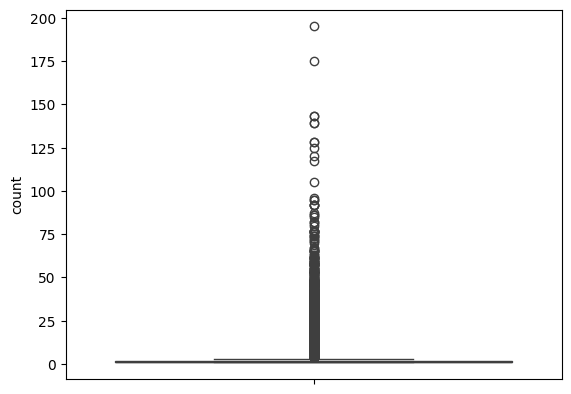

In [29]:
sns.boxplot(df_prime_pantry['reviewerID'].value_counts())

In [30]:
# keep only users with at least 2 feedbacks, one for training set and one for the test set
users_at_leat_two_feedbacks = df_prime_pantry['reviewerID'].value_counts()[df_prime_pantry['reviewerID'].value_counts() > 1]
df_prime_pantry = df_prime_pantry[df_prime_pantry['reviewerID'].isin(users_at_leat_two_feedbacks.index)].reset_index(drop=True).reset_index()

In [31]:
# map null values to remove
df_prime_pantry = df_prime_pantry.replace({'None': np.nan, '': np.nan})
df_prime_pantry = df_prime_pantry.dropna()

In [32]:
print(df_prime_pantry.shape)
df_prime_pantry.head()

(284666, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,0,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...


In [33]:
df_prime_pantry.isnull().sum()

,0
index,0
reviewerID,0
asin,0
reviewText,0
description,0
imageURL,0
imageURLHighRes,0


In [34]:
df_prime_pantry.to_csv('prime_pantry.csv', index=False)

In [35]:
df_products_cleaned.to_csv('products.csv', index=False)

In [36]:
print(f'Number of users:', df_prime_pantry['reviewerID'].nunique())

Number of users: 72969


In [37]:
print(f'Number of products:', df_prime_pantry['asin'].nunique())

Number of products: 8468


In [38]:
print(f'Number of feedbacks:', df_prime_pantry.shape[0])

Number of feedbacks: 284666


In [39]:
df_prime_pantry.isnull().sum()

,0
index,0
reviewerID,0
asin,0
reviewText,0
description,0
imageURL,0
imageURLHighRes,0


Matrix -> users (72,969) x products (8,468)

Feedbacks: 284,666

### 2.4 Download images

In [40]:
def download_image_from_url(url, path):
    try:
        img_data = requests.get(url).content
        with open(path, 'wb') as handler:
            handler.write(img_data)
    except Exception as e:
        print(f'Failed to download image {url}:', e)

In [43]:
df_prime_pantry[['asin', 'imageURL']] \
    .drop_duplicates(subset=['asin'])['imageURL'] \
    .progress_apply(lambda x: download_image_from_url(x, f'./images/{os.path.basename(x)}'))

100%|██████████| 8468/8468 [25:07<00:00,  5.62it/s]


,imageURL
0,None
2,None
30,None
41,None
44,None
...,...
284614,None
284626,None
284647,None
284669,None


### Check number of downloaded images

In [44]:
all_urls = df_prime_pantry.drop_duplicates(subset=['asin'])['imageURL'].apply(os.path.basename)
all_urls

,imageURL
0,51O32QwTXjL._SS40_.jpg
2,31R6Zwamy-L._SS40_.jpg
30,41qhwt11UQL._SS40_.jpg
41,51acsDHlwrL._SS40_.jpg
44,41Sfu3fGFxL._SS40_.jpg
...,...
284614,61WLYVe8slL._SS40_.jpg
284626,61OAI2wt1KL._SS40_.jpg
284647,61F55sec3YL._SS40_.jpg
284669,31Ig%2BruRszL._SS40_.jpg


In [45]:
import glob
all_downloaded_files = glob.glob('/content/images/*.jpg')
all_downloaded_files = list(map(os.path.basename, all_downloaded_files))
len(all_downloaded_files)

8261

In [46]:
all_urls.isin(all_downloaded_files).sum()

np.int64(8468)

In [47]:
all_urls.nunique()

8261

In [48]:
!ls -1 /content/images | wc -l

8261


In [49]:
!zip -r images.zip ./images/

Streaming output truncated to the last 5000 lines.
  adding: images/51ubIAMuysL._SS40_.jpg (deflated 1%)
  adding: images/51tzdP46ACL._SS40_.jpg (stored 0%)
  adding: images/41yadKYdz9L._SS40_.jpg (deflated 1%)
  adding: images/51dCovPtbFL._SS40_.jpg (deflated 1%)
  adding: images/516Rr5iorgL._SS40_.jpg (deflated 2%)
  adding: images/51j-usrNyGL._SS40_.jpg (deflated 1%)
  adding: images/31kJBF9YHvL._SS40_.jpg (deflated 6%)
  adding: images/414AZ3tTF1L._SS40_.jpg (deflated 4%)
  adding: images/51kc5KaW6XL._SS40_.jpg (deflated 1%)
  adding: images/51Ht-waBODL._SS40_.jpg (stored 0%)
  adding: images/41SNWc1iLWL._SS40_.jpg (deflated 5%)
  adding: images/31oz5OFVUDL._SS40_.jpg (deflated 5%)
  adding: images/41jC81mOhPL._SS40_.jpg (deflated 3%)
  adding: images/51uUUx-QFUL._SS40_.jpg (deflated 3%)
  adding: images/61GWRCDWCSL._SS40_.jpg (deflated 3%)
  adding: images/51c8mGAsYwL._SS40_.jpg (deflated 2%)
  adding: images/612aaSY9GiL._SS40_.jpg (deflated 1%)
  adding: images/312Yn37buDL._SS40_

In [51]:
from google.colab import files
files.download('/content/prime_pantry.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
files.download('/content/products.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
files.download('/content/images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Restore dataset

In [2]:
# download dataset
!gdown --id 1sF5Jn5ZJ0u3xVYizI6RZS7zmM6Xr5hmI

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sF5Jn5ZJ0u3xVYizI6RZS7zmM6Xr5hmI
From (redirected): https://drive.google.com/uc?id=1sF5Jn5ZJ0u3xVYizI6RZS7zmM6Xr5hmI&confirm=t&uuid=9f218bcb-c73e-4212-82cb-baad3e9e1065
To: /content/prime_pantry.csv
100% 409M/409M [00:06<00:00, 60.8MB/s]


In [3]:
# download images
!gdown --id 1pRCe8ZbG7zZmaXPyQmaxTMs1TlN1wksy

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pRCe8ZbG7zZmaXPyQmaxTMs1TlN1wksy
From (redirected): https://drive.google.com/uc?id=1pRCe8ZbG7zZmaXPyQmaxTMs1TlN1wksy&confirm=t&uuid=7db88c99-dbf2-4a1e-926e-4713423564ff
To: /content/images.zip
100% 7.61M/7.61M [00:00<00:00, 18.9MB/s]


In [54]:
df_prime_pantry = pd.read_csv('prime_pantry.csv')
df_prime_pantry

,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,0,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
...,...,...,...,...,...,...,...
284661,284692,A3MW5V95ZN2I4P,B01HI76XS0,Kind Bars not only taste good but very filling.,These bars are where our journey started and i...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
284662,284693,A1LJHG3JZR8WKB,B01HI76XS0,"Taste is awesome, I can read all the ingredien...",These bars are where our journey started and i...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
284663,284694,A2WN3971ONAUJF,B01HI76XS0,I like the taste and convenience of eating the...,These bars are where our journey started and i...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
284664,284695,AE4FU8QRB3KXA,B01HI76XS0,These are delicious and healthy snacks! I wit...,These bars are where our journey started and i...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [55]:
df_prime_pantry.isnull().sum()

,0
index,0
reviewerID,0
asin,0
reviewText,0
description,0
imageURL,0
imageURLHighRes,0


### Bag-of-words

https://www.kaggle.com/code/ignazio/autoencoder-for-text-in-pytorch

In [56]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# to clean data
def replace_special_chars(text):
    try:
        return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    except:
        return None

def normalise_text (text):
    text = text.str.lower()
    text = text.str.replace(r"\#","")
    text = text.str.replace(r"http\S+","URL") # \s for whitespace character and \S for non-whitespace character
    text = text.str.replace(r"@"," ")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    text = text.apply(replace_special_chars)
    return text

In [58]:
corpus = normalise_text(df_prime_pantry["reviewText"]).values.tolist()
corpus = [x for x in corpus if not isinstance(x, float)]  # remove float nan
len(corpus)

284666

In [59]:
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:
        #out = nltk.word_tokenize(i)
        out = [x for x in i.split() if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = preprocess(corpus)
corpus[:10]

['used hate milk duds longest time actually would even refer plain ol duds haha warmed lot one curiosity however despite living hours south hershey pa famous chocolate factory somehow never knew company made milk duds mean even says hershey right upper left side box could notice maybe started emphasizing word hershey front box never mysterious people telling baby ruth bars used called babe ruth bars one time know truth one though seems possible might one times overanalyzing seems like used called babe ruth bars much like hershey probably logo top left milk dud boxes time never noticed knows starting confuse pick box hershey milk duds local grocery store since cheaper way instead online',
 'love chocolate really good love caramel unlike caramels tried taste burnt',
 'still infuriating work could use better container cutter like headline says',
 'purchased saran premium plastic wrap trying reynolds press seal wrap would never use less static cling wrap remember good thing stick self typi

In [54]:
def create_vocabulary(corpus):
    '''Creates a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    ps = PorterStemmer()
    i = 0
    for s in corpus:
        for w in s.split():
            w = ps.stem(w)
            if w not in vocabulary:
                vocabulary[w] = i
                i+=1
    return vocabulary

In [55]:
vocabulary = create_vocabulary(corpus)
voc_len = len(vocabulary)
vocabulary_inv = {v: k for k, v in vocabulary.items()}  # inverted vocabulary
voc_len

29706

In [56]:
# print first N elements of the vocabulary
{k: vocabulary[k] for k in list(vocabulary.keys())[:10]}

{'use': 0,
 'hate': 1,
 'milk': 2,
 'dud': 3,
 'longest': 4,
 'time': 5,
 'actual': 6,
 'would': 7,
 'even': 8,
 'refer': 9}

In [57]:
{k: vocabulary_inv[k] for k in list(vocabulary_inv.keys())[:10]}

{0: 'use',
 1: 'hate',
 2: 'milk',
 3: 'dud',
 4: 'longest',
 5: 'time',
 6: 'actual',
 7: 'would',
 8: 'even',
 9: 'refer'}

In [58]:
def prepare_dataset(corpus, vocabulary, n_gram=1, words=True):
    '''Creates a dataset with Input column and Output column for neighboring words.
       The number of neighbors = n_gram*2'''
    inps = []
    outs = []
    for sentence in corpus:
        ssplit = sentence.split()
        w = len(ssplit)
        for idx,word in enumerate(ssplit):
            context_list = [ssplit[xi]
                    for xi in range(max(0,idx-n_gram), min(w, idx+n_gram+1))
                        if xi != idx]
            if words:
                inps.extend([word]*len(context_list))
                outs.extend(context_list)
            else:
                inps.extend([vocabulary[word]]*len(context_list))
                outs.extend([vocabulary[c] for c in context_list])
    return inps, outs

In [59]:
inps, outs = prepare_dataset(corpus, vocabulary, n_gram=2, words=True)

In [60]:
print(corpus[0])
print(inps[:10])
print(outs[:10])

used hate milk duds longest time actually would even refer plain ol duds haha warmed lot one curiosity however despite living hours south hershey pa famous chocolate factory somehow never knew company made milk duds mean even says hershey right upper left side box could notice maybe started emphasizing word hershey front box never mysterious people telling baby ruth bars used called babe ruth bars one time know truth one though seems possible might one times overanalyzing seems like used called babe ruth bars much like hershey probably logo top left milk dud boxes time never noticed knows starting confuse pick box hershey milk duds local grocery store since cheaper way instead online
['used', 'used', 'hate', 'hate', 'hate', 'milk', 'milk', 'milk', 'milk', 'duds']
['hate', 'milk', 'used', 'milk', 'duds', 'used', 'hate', 'duds', 'longest', 'hate']


In [61]:
inps, outs = prepare_dataset(corpus, vocabulary, n_gram=2, words=False)

KeyError: 'used'

In [58]:
print(corpus[0])
print(inps[:10])
print(outs[:10])

used hate milk duds longest time actually would even refer plain ol duds haha warmed lot one curiosity however despite living hours south hershey pa famous chocolate factory somehow never knew company made milk duds mean even says hershey right upper left side box could notice maybe started emphasizing word hershey front box never mysterious people telling baby ruth bars used called babe ruth bars one time know truth one though seems possible might one times overanalyzing seems like used called babe ruth bars much like hershey probably logo top left milk dud boxes time never noticed knows starting confuse pick box hershey milk duds local grocery store since cheaper way instead online
['used', 'used', 'hate', 'hate', 'hate', 'milk', 'milk', 'milk', 'milk', 'duds']
['hate', 'milk', 'used', 'milk', 'duds', 'used', 'hate', 'duds', 'longest', 'hate']


In [59]:
voc_len

29706

In [60]:
one_hot_enc = F.one_hot(torch.arange(0, voc_len), num_classes=voc_len)

In [61]:
one_hot_enc[inps[0]].float()

IndexError: too many indices for tensor of dimension 2

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)
vectorizer.fit(corpus)

CountVectorizer(analyzer=<function stemmed_words at 0x7d8db195a520>)

In [73]:
vocab = vectorizer.get_feature_names_out()
print(len(vocab))
vocab

29678


array(['00', '000', '00002', ..., 'zzzzquil', 'zzzzz', 'zzzzzzz'],
      dtype=object)

In [84]:
x = vectorizer.transform(['I liked this milk', 'like'])
x.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [77]:
df_prime_pantry.iloc[0]['reviewText']

'I used to hate Milk Duds for the longest time, and actually would even refer to them as plain ol\' duds, haha.  Now I\'ve warmed up to them a lot.  The one curiosity however is that, despite only living a few hours south of Hershey PA and their famous chocolate factory, I somehow never knew they were the company who made these Milk Duds.  I mean it even says Hershey right on the upper left side of the box!  How could I not notice?  Or maybe they just started emphasizing the word "Hershey" on the front of the box and it was never there before.  This is just as mysterious as people telling me that Baby Ruth bars used to be called Babe Ruth bars at one time.  I wouldn\'t know if there\'s any truth to that one, though it seems possible.  This might be one of those times where I\'m overanalyzing so it *seems* like they used to be called Babe Ruth bars (much like Hershey probably had their logo on the top left of these Milk Dud boxes all this time and I just never noticed until now).  Who k

In [85]:
x = vectorizer.transform([df_prime_pantry.iloc[0]['reviewText']])
x.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [88]:
x.sum()

np.int64(171)

In [87]:
torch.tensor(x.toarray()).shape

torch.Size([1, 29678])

## 3. Deep-MINE

In [ ]:
# https://discuss.pytorch.org/t/how-to-share-weights-between-two-layers/55541/2
# https://www.kaggle.com/code/ignazio/autoencoder-for-text-in-pytorch


def init_weights():
    pass


class ImageAutoEncoder(nn.Module):

    def __init__(self, n_node=100, kernel_size=3, tie_weights=True):
        super().__init__()

        # encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.fc3 = nn.Linear(25600, n_node, bias=True)

        # decoder
        self.fc4 = nn.Linear(n_node, 25600, bias=True)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=kernel_size, stride=1, padding=1)

        # utils
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU()  # TODO: change to sigmoid

        # share encoder decoder weight matrices
        if tie_weights:
            self._tie_weights()

    def _tie_weights(self):
        self.fc4.weight.data = self.fc3.weight.data.transpose(0,1)
        self.conv5.weight.data = self.conv2.weight.data.transpose(0,1)
        self.conv6.weight.data = self.conv1.weight.data.transpose(0,1)

    def forward(self, x):
        # encoder
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.pool(h)
        h = self.fc3(h.reshape(-1, 25600))
        print(h.shape)

        # decoder
        h = self.fc4(h).T
        h = h.reshape(-1, 64, 20, 20)
        h = self.upsample(h)
        h = self.conv5(h)
        x_hat = self.conv6(h)
        return x_hat

    def encode(self, x):
        # encoder
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.pool(h)
        h = self.fc3(h.reshape(-1, 25600))
        return h

    def decode(self, h):
        # decoder
        h = self.fc4(h).T
        h = h.reshape(-1, 64, 20, 20)
        h = self.upsample(h)
        h = self.conv5(h)
        x_hat = self.conv6(h)
        return x_hat


class TextAutoEncoder(nn.Module):

    def __init__(self, dim_size=32, n_node=100, hidden_size=400, tie_weights=True):
        super().__init__()

        # encoder
        self.fc1 = nn.Linear(dim_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, n_node, bias=True)

        # decoder
        self.fc3 = nn.Linear(n_node, hidden_size, bias=True)
        self.fc4 = nn.Linear(hidden_size, dim_size, bias=True)

        # utils
        self.relu = nn.ReLU()  # TODO: change to sigmoid

        # share encoder decoder weight matrices
        if tie_weights:
            self._tie_weights()

    def _tie_weights(self):
        self.fc3.weight.data = self.fc2.weight.data.transpose(0,1)
        self.fc4.weight.data = self.fc1.weight.data.transpose(0,1)

    def forward(self, x):
        # encoder
        h = self.relu(self.fc1(x))
        h = self.fc2(h)
        print(h.shape)

        # decoder
        h = self.relu(self.fc3(h))
        x_hat = self.fc4(h)
        return x_hat

    def encode(self, x):
        # encoder
        h = self.relu(self.fc1(x))
        h = self.fc2(h)
        return h

    def decode(self, h):
        # decoder
        h = self.relu(self.fc3(h))
        x_hat = self.fc4(h)
        return x_hat


model = TextAutoEncoder()
print(sum(p.numel() for p in model.parameters()))
print(model)

x = torch.randn(1, 32)
print(x.shape)
model(x).shape

106532
TextAutoEncoder(
  (fc1): Linear(in_features=32, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=32, bias=True)
  (relu): ReLU()
)
torch.Size([1, 32])
torch.Size([1, 100])


torch.Size([1, 32])

In [ ]:
model = ImageAutoEncoder()
print(sum(p.numel() for p in model.parameters()))
print(model)

x = torch.randn(1, 3, 40, 40)
print(x.shape)
model(x).shape

5223079
ImageAutoEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc3): Linear(in_features=25600, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=25600, bias=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (relu): ReLU()
)
torch.Size([1, 3, 40, 40])
torch.Size([1, 100])


torch.Size([1, 3, 40, 40])

In [ ]:
class DeepMINEModel(nn.Module):

    def __init__(self):
        super().__init__()

        ### parameters ###
        self.n_users  = 72971
        self.n_items = 8469

        # preference dimensions
        self.dim_u = 72
        self.dim_theta = 64

        # autoencoders dimensions
        self.dim_node = 100

        # regularization hyparameters
        self.lambda_m = 1/40
        self.lambda_d = 1/32
        self.lambda_r = 1/32
        self.lambda_theta = 0.1
        self.lambda_beta = 0.001
        self.lambda_Wfu = 0.001

        # lambda parameters
        self.lambda_w = 20
        self.lambda_b = 0
        self.lambda_q = 20
        self.lambda_c = 0
        self.lambda_n = 20
        self.lambda_t = 0

        ### weights ###
        # user perception factors
        self.u_users = nn.Embedding(self.n_users, self.dim_u)
        self.theta_users = nn.Embedding(self.n_users, self.dim_theta)

        # hidden information factor
        self.v_items = nn.Embedding(self.n_items, self.dim_u)

        # cognition factors
        self.a_1 = nn.Embedding(self.n_users, 1)
        self.a_2 = nn.Embedding(self.n_users, 1)
        self.a_3 = nn.Embedding(self.n_users, 1)

        # embedding layer of information integration
        self.embeddings = nn.Embedding(self.dim_node*3, self.dim_theta)

        # biases
        self.alpha_users = nn.Embedding(self.n_users, 1)
        self.beta_items = nn.Embedding(self.n_items, 1)

        # autoencoders
        self.images_autoencoder = ImageAutoEncoder(n_node=self.dim_node)
        self.descriptions_autoencoder = TextAutoEncoder(n_node=self.dim_node)
        self.reviews_autoencoder = TextAutoEncoder(n_node=self.dim_node)

    def _l2_loss(self, *tensors):
        l2_loss = 0
        for tensor in tensors:
            l2_loss += tensor.pow(2).sum()
        return l2_loss / 2

    def prediction(self,
                   user_id: int,
                   item_id: int,
                   m3,
                   d2,
                   r2,
                   ui_latent_factor,
                   ui_content_factor,
                   vj_hidden_info,
                   ui_bias,
                   ji_bias):
        ### user's cognitive styles ###
        ai1 = self.a_1(user_id)
        ai2 = self.a_2(user_id)
        ai3 = self.a_3(user_id)

        ### information integration ###
        f_c = torch.cat([ai1.T.mm(m3), ai2.T.mm(d2), ai3.T.mm(r2)], dim=-1)
        f_j = f_c.mm(self.embeddings.weight)

        # preference
        x_ij = ui_bias + ji_bias + ui_latent_factor.mm(vj_hidden_info.T) + ui_content_factor.mm(f_j.T)

        return x_ij

    def information_representation(self, image, description, review):
        # latent space
        m3 = self.images_autoencoder.encode(image)
        d2 = self.descriptions_autoencoder.encode(description)
        r2 = self.reviews_autoencoder.encode(review)

        # reconstructions
        image_hat = self.images_autoencoder.decode(m3)
        description_hat = self.descriptions_autoencoder.decode(d2)
        review_hat = self.reviews_autoencoder.decode(r2)

        return {
            'embeddings': [m3, d2, r2],
            'reconstructions': [image_hat, description_hat, review_hat]
        }

    def forward(self, user_id, p_item, p_image, p_description, p_review, n_item, n_image, n_description, n_review):
        ### information representation ###
        p_representations = self.information_representation(p_image, p_description, p_review)
        n_representations = self.information_representation(n_image, n_description, n_review)

        # latent spaces
        p_m3, p_d2, p_r2 = p_representations['embeddings']
        n_m3, n_d2, n_r2 = n_representations['embeddings']

        # reconstructions
        p_image_pred, p_description_pred, p_review_pred = p_representations['reconstructions']
        n_image_pred, n_description_pred, n_review_pred = n_representations['reconstructions']

        ### calculate user preference ###
        ui_latent_factor = self.u_users(user_id)
        ui_content_factor = self.theta_users(user_id)

        # hidden information
        p_vj_hidden_info = self.v_items(p_item)
        n_vj_hidden_info = self.v_items(n_item)

        # biases
        ui_bias = self.alpha_users(user_id)
        p_ji_bias = self.beta_items(p_item)
        n_ji_bias = self.beta_items(n_item)

        ### predictions ###
        x_ij = self.prediction(user_id, p_item, p_m3, p_d2, p_r2, ui_latent_factor, ui_content_factor, p_vj_hidden_info, ui_bias, p_ji_bias)
        x_ik = self.prediction(user_id, n_item, n_m3, n_d2, n_r2, ui_latent_factor, ui_content_factor, n_vj_hidden_info, ui_bias, n_ji_bias)

        ### losses ###
        # information representation
        l1 = (
            (self.lambda_m/2) * torch.nn.functional.mse_loss(p_image_pred, p_image)
            + (self.lambda_w/2) * self._l2_loss(self.images_autoencoder.conv1.weight, self.images_autoencoder.conv2.weight, self.images_autoencoder.fc3.weight)
            + (self.lambda_b/2) * self._l2_loss(self.images_autoencoder.conv1.bias, self.images_autoencoder.conv2.bias, self.images_autoencoder.fc3.bias)
        )
        l2 = (
            (self.lambda_d/2) * torch.nn.functional.mse_loss(p_description_pred, p_description)
            + (self.lambda_q/2) * self._l2_loss(self.descriptions_autoencoder.fc1.weight, self.descriptions_autoencoder.fc2.weight)
            + (self.lambda_c/2) * self._l2_loss(self.descriptions_autoencoder.fc1.bias, self.descriptions_autoencoder.fc2.bias)
        )
        l3 = (
            (self.lambda_r/2) * torch.nn.functional.mse_loss(p_review_pred, p_review)
            + (self.lambda_n/2) * self._l2_loss(self.reviews_autoencoder.fc1.weight, self.reviews_autoencoder.fc2.weight)
            + (self.lambda_t/2) * self._l2_loss(self.reviews_autoencoder.fc1.bias, self.reviews_autoencoder.fc2.bias)
        )

        # preference
        log_likelihood = torch.nn.functional.logsigmoid((x_ij - x_ik).unsqueeze(0)).sum()
        regularization = (
            self._l2_loss(ui_latent_factor) * (self.lambda_theta/2)
            + self._l2_loss(p_vj_hidden_info) * (self.lambda_theta/2)
            + self._l2_loss(ui_content_factor) * (self.lambda_theta/2)
            + self._l2_loss(p_ji_bias) * (self.lambda_beta/2) # B_i?
            + self._l2_loss(self.embeddings.weight) * (self.lambda_Wfu/2)
        )

        loss = -log_likelihood + regularization + l1 + l2 + l3

        return loss

In [ ]:
class DeepMINEDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        # get user's id
        user_id = self.df['reviewerID']

        # get positive implicit feedback item from user
        p_item = self.df['asin']
        p_image = torch.randn(1, 3, 40, 40)
        p_description = torch.randn(1, 32)
        p_review = torch.randn(1, 32)

        # get a random negative feedback item from user
        n_item = self.df['n_item']
        n_image = torch.randn(1, 3, 40, 40)
        n_description = torch.randn(1, 32)
        n_review = torch.randn(1, 32)

        positive_item = {
            'pos_item_id': p_item,
            'pos_item_image': p_image,
            'pos_item_description': p_description,
            'pos_item_review': p_review,
        }

        negative_item = {
            'neg_item_id': n_item,
            'neg_item_image': n_image,
            'neg_item_description': n_description,
            'neg_item_review': n_review,
        }

        return user_id, positive_item, negative_item

In [ ]:
# user id
user = torch.LongTensor([4, 34, 1])

# positive item
p_item = torch.LongTensor([50, 9, 5])
p_image = torch.randn(3, 3, 40, 40)
p_description = torch.randn(3, 32)
p_review = torch.randn(3, 32)

# negative item
n_item = torch.LongTensor([98, 78, 3])
n_image = torch.randn(3, 3, 40, 40)
n_description = torch.randn(3, 32)
n_review = torch.randn(3, 32)

model = DeepMINEModel()
model(user, p_item, p_image, p_description, p_review, n_item, n_image, n_description, n_review)

tensor(2066.3901, grad_fn=<AddBackward0>)

In [ ]:
model = DeepMINEModel()
training_data = DeepMINEDataset()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
optimizer = nn.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(100):
    for data in train_dataloader:
        optimizer.zero_grad()
        user_id, positive_item, negative_item = data

        p_item, p_image, p_description, p_review = positive_item['pos_item_id'], positive_item['pos_item_image'], positive_item['pos_item_description'], positive_item['pos_item_review']
        n_item, n_image, n_description, n_review = positive_item['neg_item_id'], positive_item['neg_item_image'], positive_item['neg_item_description'], positive_item['neg_item_review']

        loss = model(user, p_item, p_image, p_description, p_review, n_item, n_image, n_description, n_review)
        loss.backward()
        optimizer.step()

In [ ]:
### parameters ###
n_users  = 200
n_items = 500

# preference dimensions
dim_u = 20
dim_theta = 4

# autoencoders dimensions
dim_node = 100

# regularization hyparameters
lambda_m = 1/40
lambda_d = 1/32
lambda_r = 1/32
lambda_theta = 0.1
lambda_beta = 0.001
lambda_Wfu = 0.001

# lambda parameters
lambda_w = 20
lambda_b = 0
lambda_q = 20
lambda_c = 0
lambda_n = 20
lambda_t = 0

### Weights

In [ ]:
# user perception factors
u_users = nn.Embedding(n_users, dim_u)
theta_users = nn.Embedding(n_users, dim_theta)

# hidden information factor
v_items = nn.Embedding(n_items, dim_u)

# cognition factors
a_1 = nn.Embedding(n_users, 1)
a_2 = nn.Embedding(n_users, 1)
a_3 = nn.Embedding(n_users, 1)

# embedding layer of information integration
embeddings = nn.Embedding(dim_node*3, dim_theta)

# biases
alpha_users = nn.Embedding(n_users, 1)
beta_items = nn.Embedding(n_items, 1)

### Models

In [ ]:
# autoencoders
images_autoencoder = ImageAutoEncoder()
descriptions_autoencoder = TextAutoEncoder()
reviews_autoencoder = TextAutoEncoder()

### Forward

In [ ]:
def prediction(user, item, image, description, review):
    ### information representation ###
    m3 = images_autoencoder.encode(image)
    d2 = descriptions_autoencoder.encode(description)
    r2 = reviews_autoencoder.encode(review)

    ### user's cognitive styles ###
    ai1 = a_1(user)
    ai2 = a_2(user)
    ai3 = a_3(user)

    ### information integration ###
    f_c = torch.cat([ai1.mm(m3), ai2.mm(d2), ai3.mm(r2)], dim=-1)
    f_j = f_c.mm(embeddings.weight)

    ### calculate user preference ###
    ui_latent_factor = u_users(user)
    ui_content_factor = theta_users(user)

    # hidden information
    vj_hidden_info = v_items(item)

    # biases
    ui_bias = alpha_users(user)
    ji_bias = beta_items(item)

    # preference
    x_ij = ui_bias + ji_bias + ui_latent_factor.mm(vj_hidden_info.T) + ui_content_factor.mm(f_j.T)

    return x_ij

In [ ]:
# user id
user = torch.LongTensor([4])

# positive item
p_item = torch.LongTensor([50])
p_image = torch.randn(1, 3, 40, 40)
p_description = torch.randn(1, 32)
p_review = torch.randn(1, 32)

# negative item
n_item = torch.LongTensor([98])
n_image = torch.randn(1, 3, 40, 40)
n_description = torch.randn(1, 32)
n_review = torch.randn(1, 32)

# predictions
x_ij = prediction(user, p_item, p_image, p_description, p_review)
x_ik = prediction(user, n_item, n_image, n_description, n_review)
x_ij - x_ik

tensor([[10.5123]], grad_fn=<SubBackward0>)

In [ ]:
-torch.nn.functional.logsigmoid((x_ij - x_ik).unsqueeze(0)).sum()

tensor(2.7198e-05, grad_fn=<NegBackward0>)

Next steps:
- Regularization parameters to loss function OK
- Create dataloaders
- Analyze the data OK
- Evaluation methods

Perhaps check these references:

- https://github.com/sh0416/bpr/blob/master/train.py
- https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bpr_deep_dive.ipynb
- https://medium.com/data-science/recommender-system-bayesian-personalized-ranking-from-implicit-feedback-78684bfcddf6
- https://github.com/PreferredAI/cornac/blob/93058c04a15348de60b5190bda90a82dafa9d8b6/cornac/models/vbpr/recom_vbpr.py#L249

**BPR: Bayesian Personalized Ranking**

![](https://seunghan96.github.io/assets/img/recsys/24-4.png)

**VBPR: Visual Bayesian Personalized Ranking**

- Paper: https://arxiv.org/pdf/1510.01784
- Github: https://github.com/aaossa/VBPR-PyTorch
- Github: https://github.com/arogers1/VBPR

![](https://raw.githubusercontent.com/aaossa/VBPR-PyTorch/main/vbpr.png?raw=True)

![](https://velog.velcdn.com/images/hyxxnii/post/732ba898-f3bb-4814-870e-0e49b7e13194/image.png)